<a href="https://colab.research.google.com/github/codithj/stock_prediction_with_ml/blob/main/Multivariate_Time_Series_Models_for_Stock_Market_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Remote data access for pandas
import pandas_datareader as webreader
# Mathematical functions 
import math 
# Fundamental package for scientific computing with Python
import numpy as np 
# Additional functions for analysing and manipulating data
import pandas as pd 
# Date Functions
from datetime import date, timedelta, datetime
# This function adds plotting functions for calender dates
from pandas.plotting import register_matplotlib_converters
# Important package for visualization - we use this to plot the market data
import matplotlib.pyplot as plt 
# Formatting dates
import matplotlib.dates as mdates
# Packages for measuring model performance / errors
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Deep learning library, used for neural networks
from keras.models import Sequential 
# Deep learning classes for recurrent and regular densely-connected layers
from keras.layers import LSTM, Dense, Dropout
# EarlyStopping during model training
from keras.callbacks import EarlyStopping
# This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
from sklearn.preprocessing import RobustScaler


Loading the data

In [2]:
# Setting the timeframe for the data extraction
today = date.today()
date_today = today.strftime("%Y-%m-%d")
date_start = '2010-01-01'

# Getting NASDAQ quotes
stockname = 'NASDAQ'
symbol = '^IXIC'
df = webreader.DataReader(
    symbol, start=date_start, end=date_today, data_source="yahoo"
)

# Create a quick overview of the dataset
train_dfs = df.copy()
train_dfs

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,2311.149902,2294.409912,2294.409912,2308.419922,1931380000,2308.419922
2010-01-05,2313.729980,2295.620117,2307.270020,2308.709961,2367860000,2308.709961
2010-01-06,2314.070068,2295.679932,2307.709961,2301.090088,2253340000,2301.090088
2010-01-07,2301.300049,2285.219971,2298.090088,2300.050049,2270050000,2300.050049
2010-01-08,2317.600098,2290.610107,2292.239990,2317.169922,2145390000,2317.169922
...,...,...,...,...,...,...
2021-02-26,13368.059570,13024.530273,13232.900391,13192.349609,5883880000,13192.349609
2021-03-01,13596.589844,13362.660156,13406.160156,13588.830078,5047710000,13588.830078
2021-03-02,13601.330078,13352.000000,13599.450195,13358.790039,4920320000,13358.790039


Exploring the data

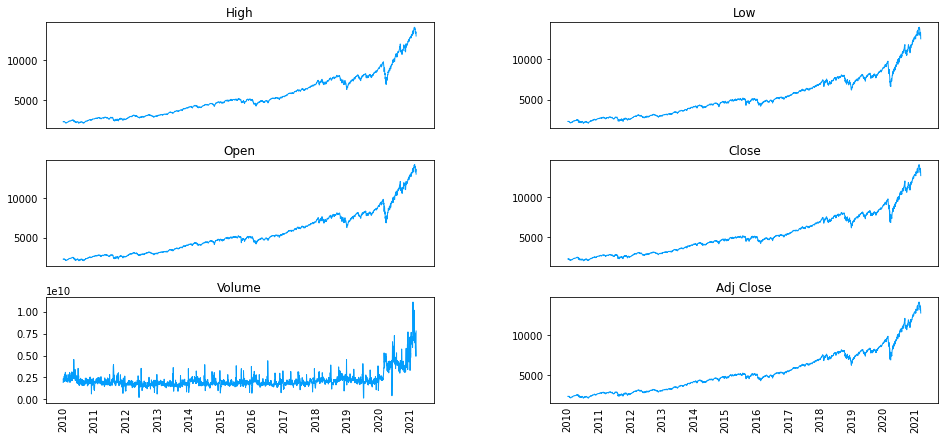

In [3]:

# Plot each column
register_matplotlib_converters()
nrows = 3
ncols = int(round(train_dfs.shape[1] / nrows, 0))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(16, 7))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
x = train_dfs.index
columns = train_dfs.columns
f = 0
for i in range(nrows):
    for j in range(ncols):
        ax[i, j].xaxis.set_major_locator(mdates.YearLocator())
        assetname = columns[f]
        y = train_dfs[assetname]
        f += 1
        ax[i, j].plot(x, y, color='#039dfc', label=stockname, linewidth=1.0)
        ax[i, j].set_title(assetname)
        ax[i, j].tick_params(axis="x", rotation=90, labelsize=10, length=0)   
#plt.show()

Preprocessing and feature selection

In [4]:
# Indexing Batches
train_df = train_dfs.sort_values(by=['Date']).copy()

# We safe a copy of the dates index, before we need to reset it to numbers
date_index = train_df.index

# Adding Month and Year in separate columns
d = pd.to_datetime(train_df.index)
train_df['Month'] = d.strftime("%m") 
train_df['Year'] = d.strftime("%Y") 

# We reset the index, so we can convert the date-index to a number-index
train_df = train_df.reset_index(drop=True).copy()
train_df.head(5)

,High,Low,Open,Close,Volume,Adj Close,Month,Year
0,2311.149902,2294.409912,2294.409912,2308.419922,1931380000,2308.419922,01,2010
1,2313.729980,2295.620117,2307.270020,2308.709961,2367860000,2308.709961,01,2010
2,2314.070068,2295.679932,2307.709961,2301.090088,2253340000,2301.090088,01,2010
3,2301.300049,2285.219971,2298.090088,2300.050049,2270050000,2300.050049,01,2010
4,2317.600098,2290.610107,2292.239990,2317.169922,2145390000,2317.169922,01,2010


In [5]:
# List of considered Features
FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume', 'Month', 
            #'Adj Close'
           ]
print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# Print the tail of the dataframe
data_filtered.tail()

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume', 'Month']


,High,Low,Open,Close,Volume,Month
2806,13368.059570,13024.530273,13232.900391,13192.349609,5883880000,02
2807,13596.589844,13362.660156,13406.160156,13588.830078,5047710000,03
2808,13601.330078,13352.000000,13599.450195,13358.790039,4920320000,03
2809,13372.519531,12995.070312,13336.250000,12997.750000,5493960000,03
2810,13068.709961,12553.959961,12953.990234,12723.469727,7799710000,03


In [6]:

# Calculate the number of rows in the data
nrows = data_filtered.shape[0]
np_data_unscaled = np.array(data_filtered)
np_data_unscaled = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data_unscaled.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = RobustScaler()
np_data = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = RobustScaler()
df_Close = pd.DataFrame(data_filtered['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(2811, 6)


In [7]:
#Settings
sequence_length = 100

# Split the training data into x_train and y_train data sets
# Get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data.shape[0] * 0.8) #2616

# Create the training data
train_data = np_data[0:train_data_len, :]
x_train, y_train = [], []
# The RNN needs data with the format of [samples, time steps, features].
# Here, we create N samples, 100 time steps per sample, and 2 features
for i in range(100, train_data_len):
    x_train.append(train_data[i-sequence_length:i,:]) #contains 100 values 0-100 * columsn
    y_train.append(train_data[i, 0]) #contains the prediction values for validation
    
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Create the test data
test_data = np_data[train_data_len - sequence_length:, :]

# Split the test data into x_test and y_test
x_test, y_test = [], []
test_data_len = test_data.shape[0]
for i in range(sequence_length, test_data_len):
    x_test.append(test_data[i-sequence_length:i,:]) #contains 100 values 0-100 * columsn
    y_test.append(test_data[i, 0]) #contains the prediction values for validation
# Convert the x_train and y_train to numpy arrays
x_test, y_test = np.array(x_test), np.array(y_test)

# Convert the x_train and y_train to numpy arrays
x_test = np.array(x_test); y_test = np.array(y_test)
    
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(2149, 100, 6) (2149,)
(562, 100, 6) (562,)



Model training

In [8]:
# Configure the neural network model
model = Sequential()

# Model with 100 Neurons 
# inputshape = 100 Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=False, 
               input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(Dense(1, activation='relu'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

600 100 6


In [ ]:

# Training the model
epochs = 5
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = model.fit(x_train, y_train, batch_size=16, 
                    epochs=epochs, callbacks=[early_stop])

Epoch 1/5
135/135 [==============================] - 96s 694ms/step - loss: 0.0997
Epoch 2/5
135/135 [==============================] - 95s 701ms/step - loss: 0.0915
Epoch 3/5
124/135 [==========================>...] - ETA: 7s - loss: 0.0984

In [ ]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(5, 5), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()